In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_classif

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# tree models
from sklearn.tree import DecisionTreeRegressor

# ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# xgb model
import xgboost as xgb
from xgboost import XGBRegressor

# imputing
from sklearn.impute import SimpleImputer, KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

## Daten laden

In [47]:
df_raw = pd.read_csv('../data/immo_data_clean.csv', low_memory=False)

# print all columns, so we can see all columns
pd.set_option('display.max_columns', None)
print(df_raw.shape)

(21466, 60)


In [48]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21466 entries, 0 to 21465
Data columns (total 60 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price_cleaned                      21466 non-null  float64
 1   Zip                                21466 non-null  int64  
 2   kanton                             20764 non-null  object 
 3   Municipality                       21256 non-null  object 
 4   type_unified                       21466 non-null  object 
 5   Year built:                        6933 non-null   float64
 6   Availability_Categorized           21466 non-null  object 
 7   Living_area_unified                20563 non-null  float64
 8   Floor_unified                      9987 non-null   float64
 9   Floor_space_merged                 2774 non-null   float64
 10  Plot_area_unified                  7705 non-null   float64
 11  Rooms_new                          20772 non-null  flo

In [49]:
df_raw = df_raw.drop(['Municipality', 'lon', 'lat'], axis=1)

In [50]:
# Identify columns with object dtype
categorical_columns = df_raw.select_dtypes(include=['object']).columns.tolist()

# Identify columns with numerical dtype
numerical_columns = df_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Convert to dummy variables
df_raw = pd.get_dummies(df_raw, columns=categorical_columns, drop_first=True, dtype=int)

df_raw.shape

(21466, 104)

In [51]:
# check for missing values and only print columns with missing values
df_raw.isnull().sum()[df_raw.isnull().sum() > 0]

Year built:            14533
Living_area_unified      903
Floor_unified          11479
Floor_space_merged     18692
Plot_area_unified      13761
Rooms_new                694
gde_politics_bdp        8488
gde_politics_cvp         302
gde_politics_evp        4001
gde_politics_fdp         131
gde_politics_glp        5691
gde_politics_gps         444
gde_politics_pda       10284
gde_politics_rights     6466
gde_politics_sp           82
gde_politics_svp          49
dtype: int64

In [52]:
df_raw = df_raw.dropna(axis=1)

In [53]:
df_raw = df_raw[df_raw['price_cleaned'] > 10000.00]

df_raw.shape

(21444, 88)

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Zielvariable definieren
target_variable = 'price_cleaned'

# Variablen für die Analyse auswählen (ohne Zielvariable)
X = df_raw.drop(target_variable, axis=1)

# Definieren Sie die maximale Anzahl der Features
max_features = 10

while len(X.columns) > max_features:
    # Hinzufügen einer Konstanten für VIF-Berechnung
    X_const = add_constant(X)
    
    # Berechnung der VIF-Werte
    vifs = pd.Series(
        [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
        index=X_const.columns
    )

    # Entfernen der Konstanten aus der VIF-Berechnung
    vifs = vifs.drop('const')

    # Finden der Variable mit dem höchsten VIF-Wert
    max_vif = vifs.idxmax()

    # Falls der höchste VIF-Wert unter dem Schwellenwert liegt, brechen Sie die Schleife ab
    if vifs[max_vif] < 10:
        break

    # Entfernen der Variable mit dem höchsten VIF-Wert
    print(f'Entfernen: {max_vif}, VIF: {vifs[max_vif]}')
    X = X.drop(max_vif, axis=1)

# Finale Liste der Variablen
print('Verbleibende Variablen:', X.columns)


C:\Users\Oliver\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Oliver\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Entfernen: gde_area_agriculture_percentage, VIF: inf
Entfernen: gde_workers_total, VIF: 3535183761.019875
Entfernen: gde_private_apartments, VIF: 858.7652867647471
Entfernen: gde_population, VIF: 41.60466367610636
Entfernen: WorkplaceDensityM, VIF: 37.925044507773535
Entfernen: ForestDensityM, VIF: 20.077275486708032
Entfernen: PopulationDensityM, VIF: 16.922387466847493
Entfernen: Zip, VIF: 15.258645508655597
Entfernen: NoisePollutionRoadM, VIF: 12.674581869902877
Verbleibende Variablen: Index(['gde_workers_sector1', 'gde_workers_sector2', 'gde_workers_sector3',
       'distanceToTrainStation', 'gde_area_forest_percentage',
       'gde_area_nonproductive_percentage', 'gde_area_settlement_percentage',
       'gde_average_house_hold', 'gde_empty_apartments',
       'gde_foreigners_percentage', 'gde_new_homes_per_1000',
       'gde_pop_per_km2', 'gde_social_help_quota', 'gde_tax',
       'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionR

In [55]:
# df nur mit den verbleibenden Variablen
df = pd.concat([df_raw[target_variable], X], axis=1)

df.shape

(21444, 79)

In [56]:
# Berechnung der Korrelationen
correlation_matrix = df.corr()

# Korrelationen der Features mit der Zielvariable
target_correlations = correlation_matrix[target_variable].abs().sort_values(ascending=False)

# Festlegen eines Korrelationsschwellenwerts
correlation_threshold = 0.1  # Beispielwert, anpassen nach Bedarf

# Auswahl von Variablen, die über dem Schwellenwert liegen
selected_variables = target_correlations[target_correlations > correlation_threshold].index.tolist()

# Entfernen der Zielvariable aus der Liste
selected_variables.remove(target_variable)

# Endgültiger DataFrame mit ausgewählten Variablen
df_final = df_raw[selected_variables + [target_variable]]

print(f"Ausgewählte Variablen: {selected_variables}")

Ausgewählte Variablen: ['kanton_GE', 'gde_area_settlement_percentage', 'type_unified_flat', 'gde_pop_per_km2', 'gde_foreigners_percentage', 'type_unified_detached-house', 'RiversAndLakesL', 'type_unified_villa', 'kanton_VD', 'gde_area_forest_percentage', 'NoisePollutionRoadL', 'gde_empty_apartments', 'kanton_VS', 'gde_workers_sector3', 'WorkplaceDensityS', 'WorkplaceDensityL', 'NoisePollutionRoadS', 'RiversAndLakesM']


In [57]:
# df nur mit den Ausgewählte Variablen
df = df[selected_variables + [target_variable]]

df.shape

(21444, 19)

## Train Test Split

In [58]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop("price_cleaned", axis=1)
y_train = train["price_cleaned"]

X_test = test.drop("price_cleaned", axis=1)
y_test = test["price_cleaned"]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (17155, 18)
y_train shape:  (17155,)
X_test shape:  (4289, 18)
y_test shape:  (4289,)


## Impuation

In [59]:
cols = X_train.columns

X_train_with_na = X_train.copy()
X_test_with_na = X_test.copy()

imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)

## Standardisierung

In [60]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

## Modelle

In [61]:
mape_lst = {}

### Modell 1: Multiple Linear Regression (Benchmark)
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Das erste Modell ist eine multiple lineare Regression und dient als Benchmark für die anderen Modelle.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


Best parameters:  {'copy_X': True, 'fit_intercept': True, 'positive': False}
MAPE: 0.8545
R2: 0.2039


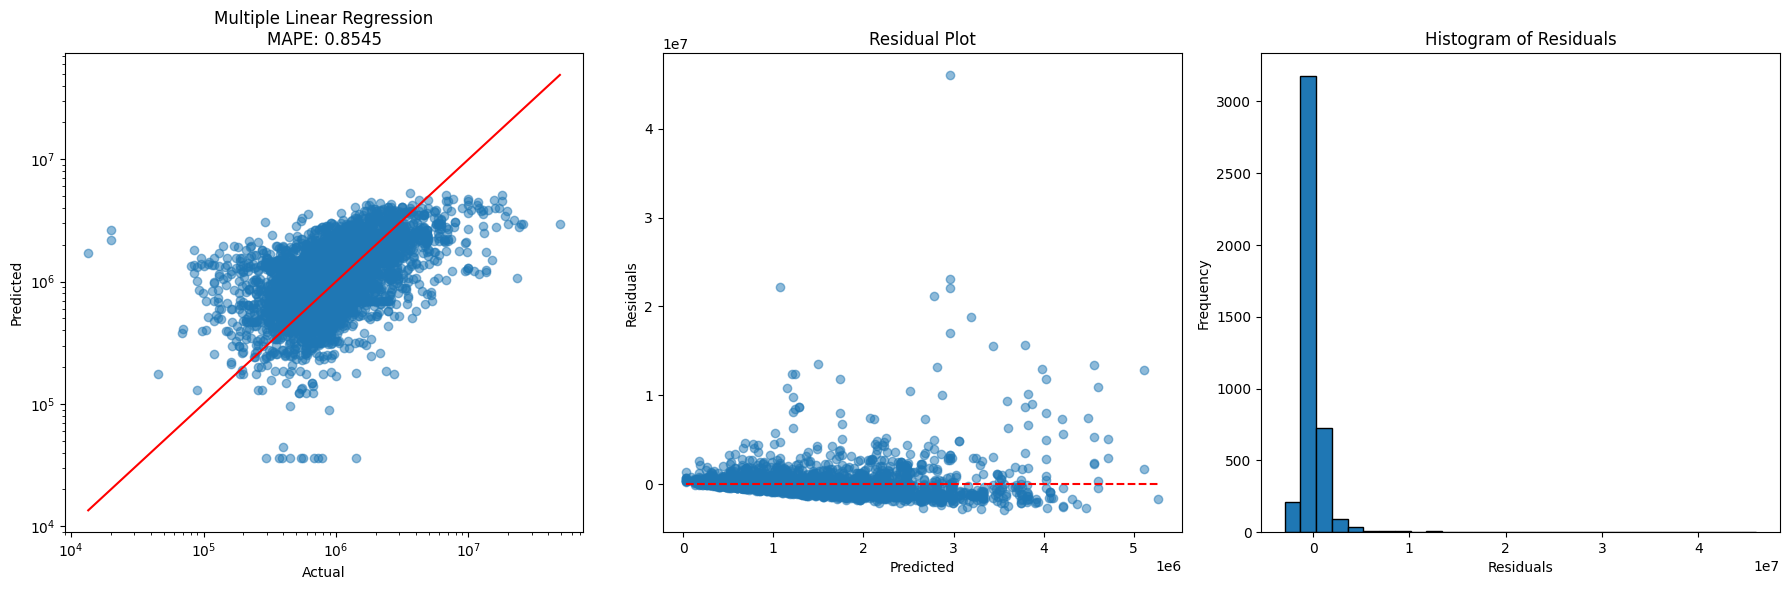

In [62]:
def mlr_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a multiple linear regression model with grid search cv
    """
    lin_reg = LinearRegression()

    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False]
    }

    grid_mlr = GridSearchCV(lin_reg, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_mlr.fit(X_train, y_train)

    best_params = grid_mlr.best_params_
    print("Best parameters: ", best_params)

    y_pred_mlr = grid_mlr.predict(X_test)

    mape_mlr = round(mean_absolute_percentage_error(y_test, y_pred_mlr), 4)
    print('MAPE: {}'.format(mape_mlr))

    r2_mlr = round(r2_score(y_test, y_pred_mlr), 4)
    print('R2: {}'.format(r2_mlr))

    plt.figure(figsize=(18, 6))
    
    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_mlr, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Multiple Linear Regression\nMAPE: {}'.format(mape_mlr))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_mlr
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_mlr, residuals, alpha=0.5)
    plt.hlines(0, np.min(y_pred_mlr), np.max(y_pred_mlr), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_mlr, mape_mlr

mlr_regression, mape_mlr = mlr_model(X_train, 
                           y_train, 
                           X_test, 
                           y_test, 
                           cv=5)

mape_lst['Multiple Linear Regression'] = mape_mlr

MAPE gibt her einen durchschnittlichen prozentualen Fehler von 1.77% zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an.

### Modell 2: Ridge Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'alpha': 2000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42}
MAPE: 0.8461
R2: 0.2009


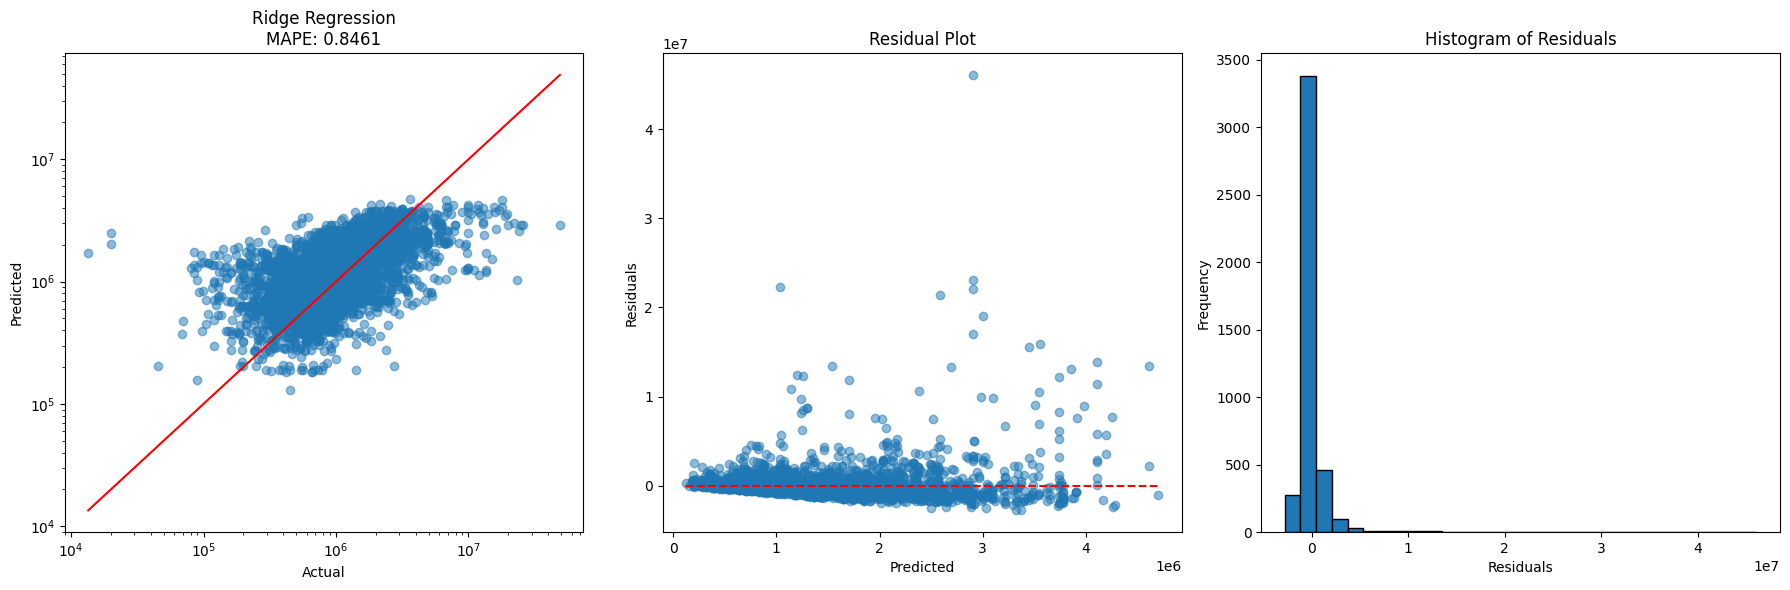

In [63]:
def ridge_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[100]):
    """ Creates a Ridge regression model with grid search cv
    """
    ridge = Ridge()

    param_grid = {
        'alpha': alphas,
        'fit_intercept': [True],
        'positive': [False],
        'max_iter': iterations,
        'random_state': [42]
    }

    grid_ridge = GridSearchCV(ridge, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_ridge.fit(X_train, y_train)

    best_params = grid_ridge.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_ridge = grid_ridge.predict(X_test)

    mape_ridge = round(mean_absolute_percentage_error(y_test, y_pred_ridge), 4)
    print('MAPE: {}'.format(mape_ridge))

    r2_ridge = round(r2_score(y_test, y_pred_ridge), 4)
    print('R2: {}'.format(r2_ridge))

    plt.figure(figsize=(18, 6))
    
    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_ridge, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Ridge Regression\nMAPE: {}'.format(mape_ridge))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_ridge
    
    plt.subplot(1, 3, 2)

    plt.scatter(y_pred_ridge, residuals, alpha=0.5)
    plt.hlines(0, np.min(y_pred_ridge), np.max(y_pred_ridge), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_ridge, mape_ridge

ridge_regression, mape_ridge = ridge_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(1000, 20000, 400),
    cv=5,
    iterations=[100])

mape_lst['Ridge Regression'] = mape_ridge

### Modell 3: Lasso Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'selection': 'cyclic', 'max_iter': 2000, 'fit_intercept': True, 'alpha': 10000.0}
MAPE: 0.8475
R2: 0.2027


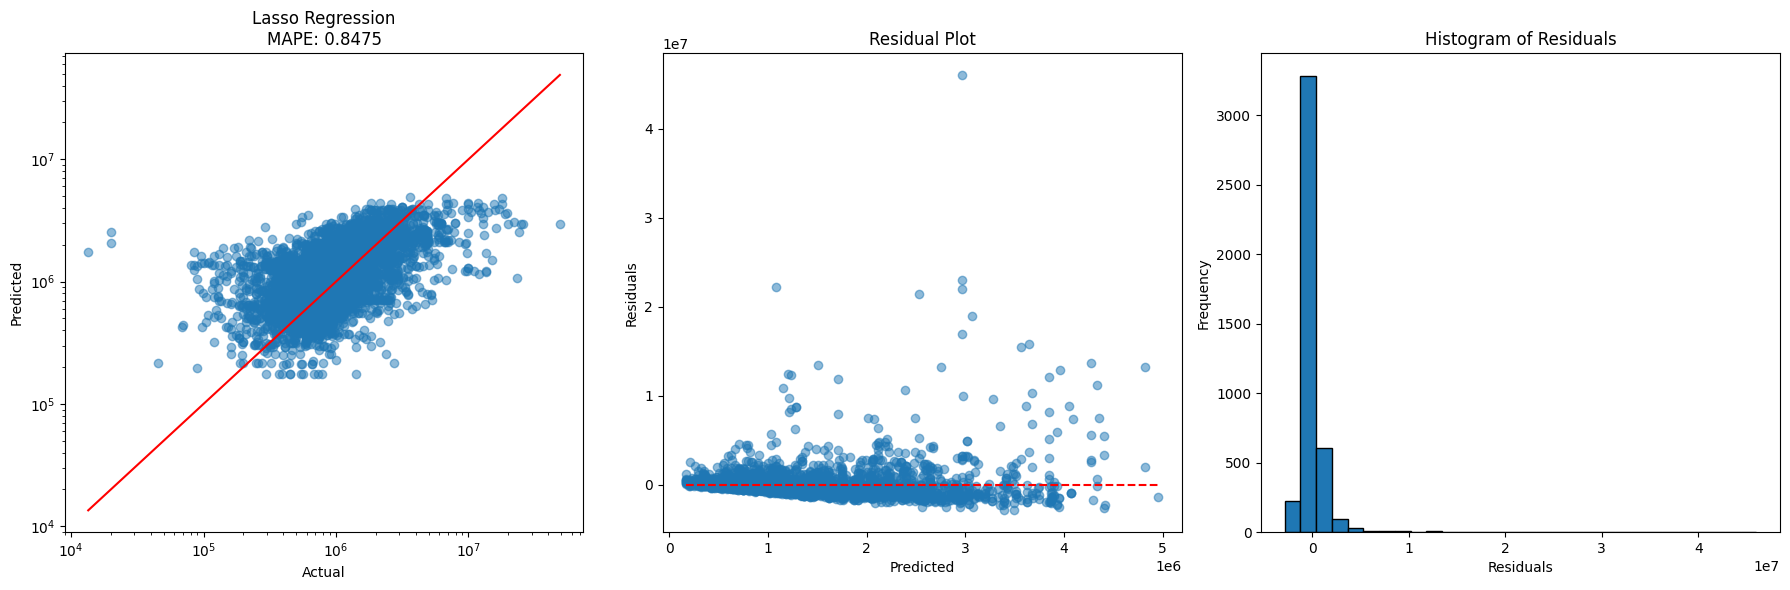

In [64]:
def lasso_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[1000]):
    """ Creates a Lasso regression model with grid search cv
    """
    lasso = Lasso()

    param_grid = {
        'alpha': alphas,
        'fit_intercept': [True, False],
        'max_iter': iterations,
        'selection': ['random', 'cyclic']
    }

    grid_lasso = RandomizedSearchCV(lasso, param_grid, n_iter=100, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1, random_state=42)

    grid_lasso.fit(X_train, y_train)

    best_params = grid_lasso.best_params_
    print('Best parameters:', best_params)

    y_pred_lasso = grid_lasso.predict(X_test)

    mape_lasso = round(mean_absolute_percentage_error(y_test, y_pred_lasso), 4)
    print('MAPE:', mape_lasso)

    r2_lasso = round(r2_score(y_test, y_pred_lasso), 4)
    print('R2:', r2_lasso)

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_lasso, alpha=0.5)
    plot_lin = np.linspace(min(y_test), max(y_test), 100)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Lasso Regression\nMAPE: {}'.format(mape_lasso))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_lasso
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_lasso, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_lasso), max(y_pred_lasso), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_lasso, mape_lasso

lasso_regression, mape_lasso = lasso_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(10, 10000, 100),
    cv=5,
    iterations=[1000, 2000]
)

mape_lst['Lasso Regression'] = mape_lasso


### Modell 4: XGBoost
[Dokumentation](https://xgboost.readthedocs.io/en/latest/)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 42}
MAPE: 0.5689
R2: 0.3962


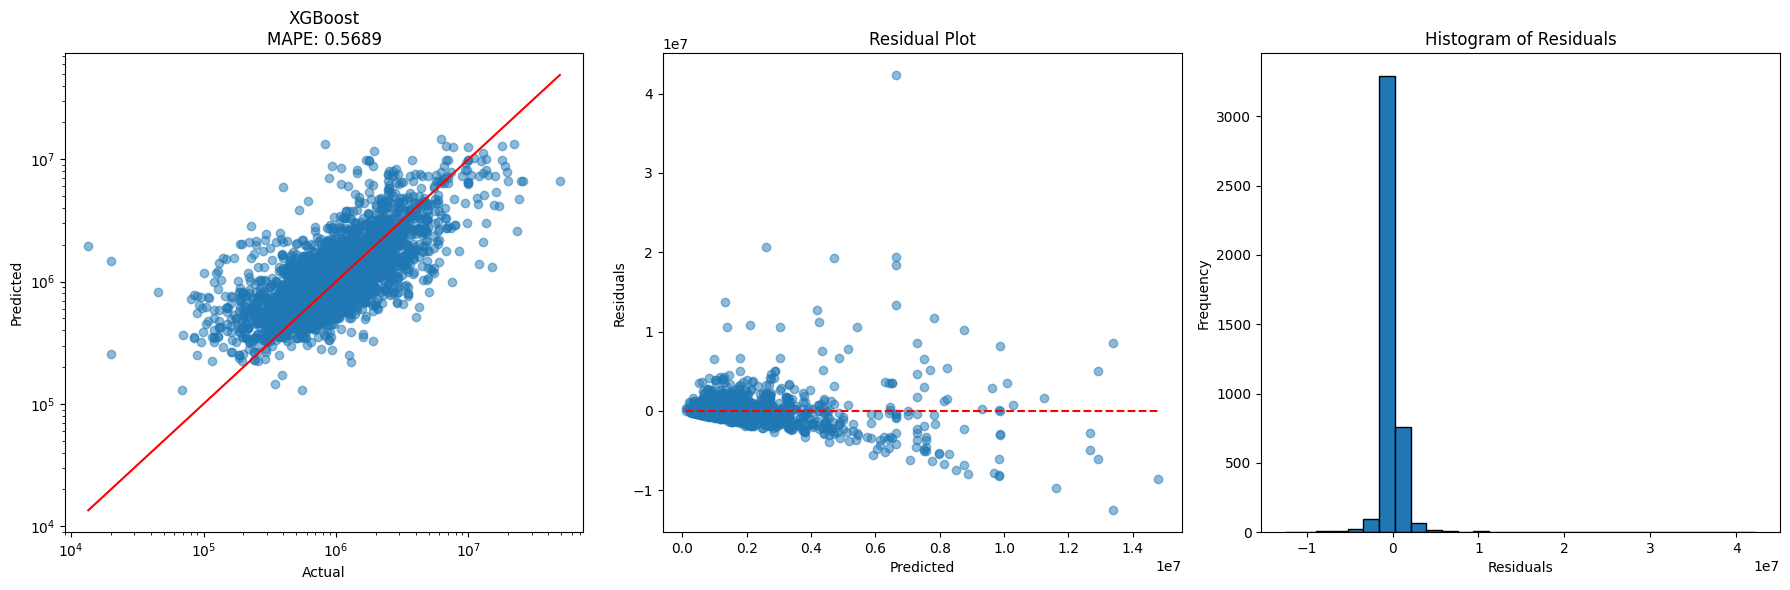

In [65]:
def xgb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[12], learning_rate=[0.1], booster=['gbtree']):
    """ Creates a XGBoost model with grid search cv
    """
    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, y_train)

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE: {}'.format(mape_xgb))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_xgb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('XGBoost\nMAPE: {}'.format(mape_xgb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_xgb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_xgb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_xgb), max(y_pred_xgb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_xgb, mape_xgb

xgb_regression, mape_xgb = xgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 6, 9, 12, 15],
    learning_rate = [0.1],
    booster = ['gbtree']
)

mape_lst['XGBoost'] = mape_xgb

### XGBoost Feature Importance

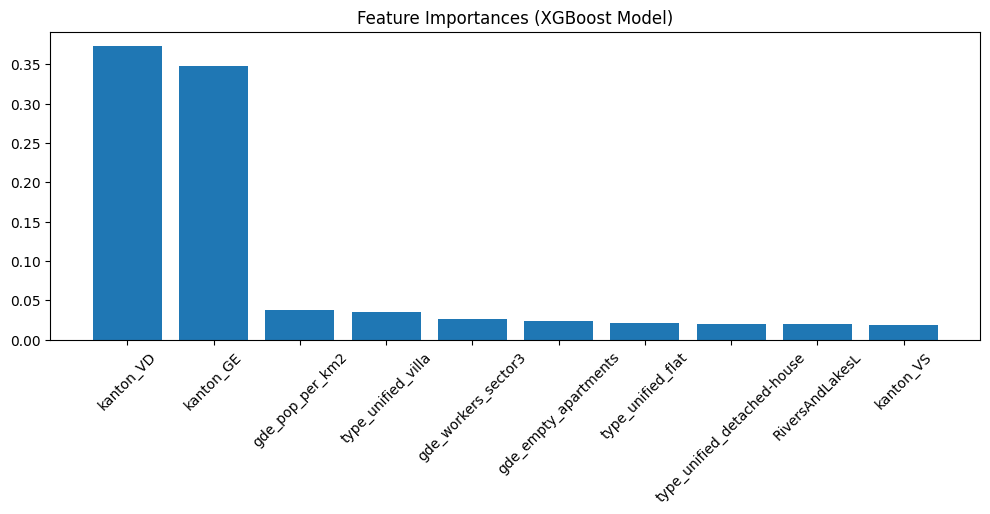

In [66]:
# Extract the best estimator from the GridSearchCV object
best_xgb_model = xgb_regression.best_estimator_

# Get feature importances
importances = best_xgb_model.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[importances], 'importance': best_xgb_model.feature_importances_[importances]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (XGBoost Model)')
plt.show()

### Modell 5: Random Forest
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'random_state': 42}
MAPE: 0.579
R2: 0.4129


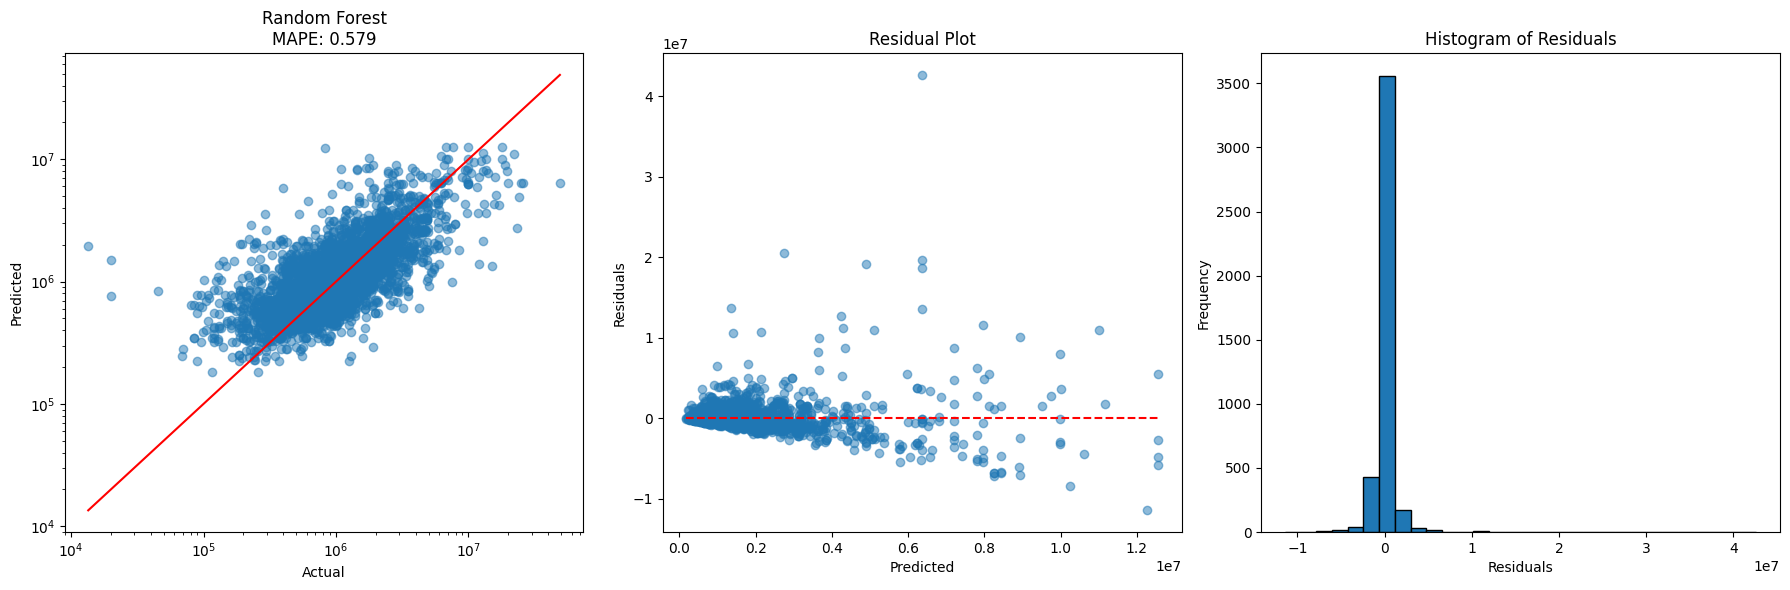

In [67]:
def rf_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a Random Forest model with grid search cv
    """
    rf = RandomForestRegressor()

    param_grid = {
        'random_state': [42]
    }

    grid_rf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_rf.fit(X_train, y_train)

    best_params = grid_rf.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_rf = grid_rf.predict(X_test)

    mape_rf = round(mean_absolute_percentage_error(y_test, y_pred_rf), 4)
    print('MAPE: {}'.format(mape_rf))

    r2_rf = round(r2_score(y_test, y_pred_rf), 4)
    print('R2: {}'.format(r2_rf))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest\nMAPE: {}'.format(mape_rf))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_rf

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_rf, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_rf), max(y_pred_rf), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_rf, mape_rf

rf_regression, mape_rf = rf_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
)

mape_lst['Random Forest'] = mape_rf

### Random Forest Feature Importance

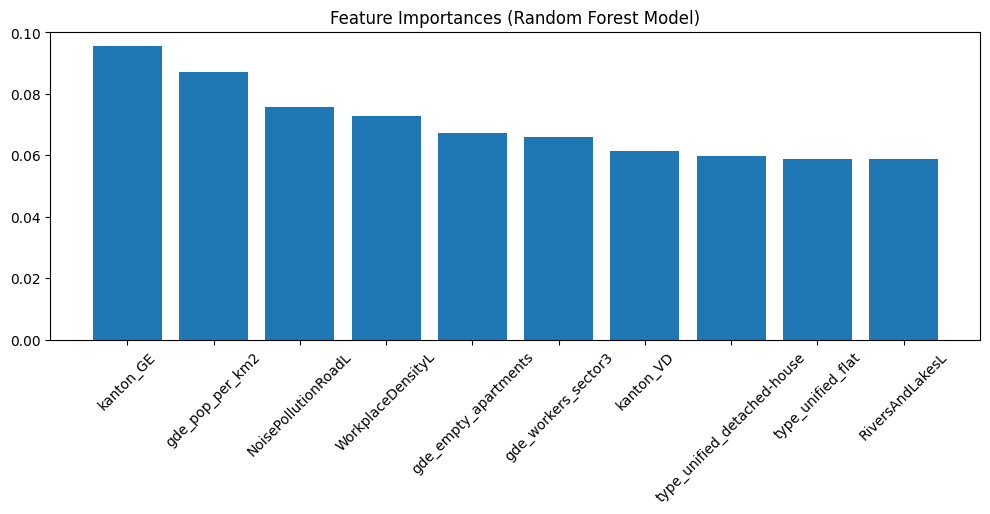

In [68]:
# feature importances for random forest
best_rf_model = rf_regression.best_estimator_.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[best_rf_model], 'importance': rf_regression.best_estimator_.feature_importances_[best_rf_model]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (Random Forest Model)')
plt.show()

### Modell 6: Hist Gradient Boosting Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 20, 'random_state': 42}
MAPE: 0.6307
R2: 0.4122


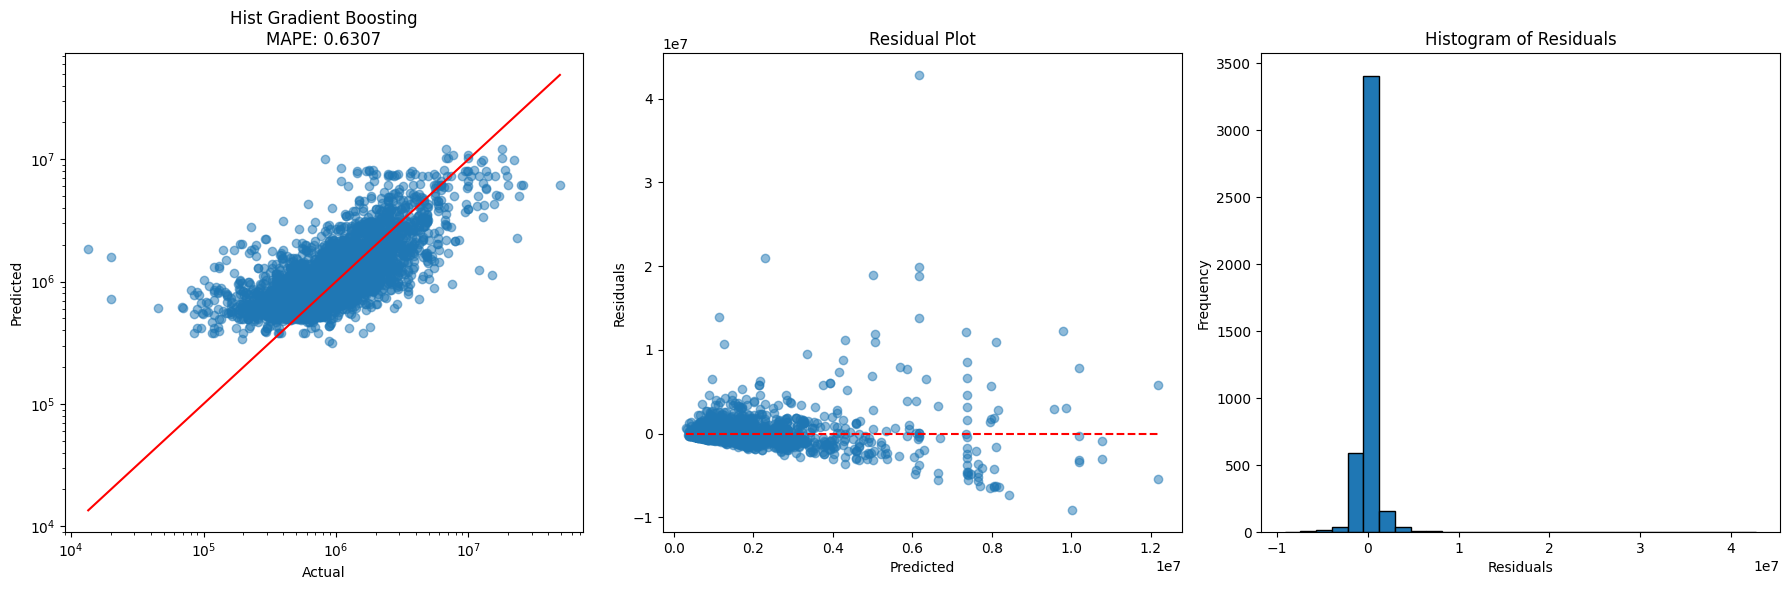

In [69]:
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv=5, 
        max_depth=[None], 
        learning_rate=[0.1], 
        l2_regularization=[0.0], 
        max_leaf_nodes=[31],
        min_samples_leaf=[20]):
    
    """ Creates a Hist Gradient Boosting model with grid search cv
    """
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'l2_regularization': l2_regularization,
        'max_leaf_nodes': max_leaf_nodes,
        'min_samples_leaf': min_samples_leaf,
        'random_state': [42]
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, y_train)

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE: {}'.format(mape_hgb))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_hgb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Hist Gradient Boosting\nMAPE: {}'.format(mape_hgb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_hgb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_hgb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_hgb), max(y_pred_hgb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_hgb, mape_hgb

hgb_regression, mape_hgb = hgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 3, 6, 9],
    learning_rate = [0.1],
    l2_regularization = [0.0, 0.1],
    max_leaf_nodes = [31, 50],
    min_samples_leaf = [20, 50],
)

mape_lst['Hist Gradient Boosting'] = mape_hgb

### Modell 7: Gradient Boosting Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'random_state': 42}
MAPE: 0.5954
R2: 0.3522


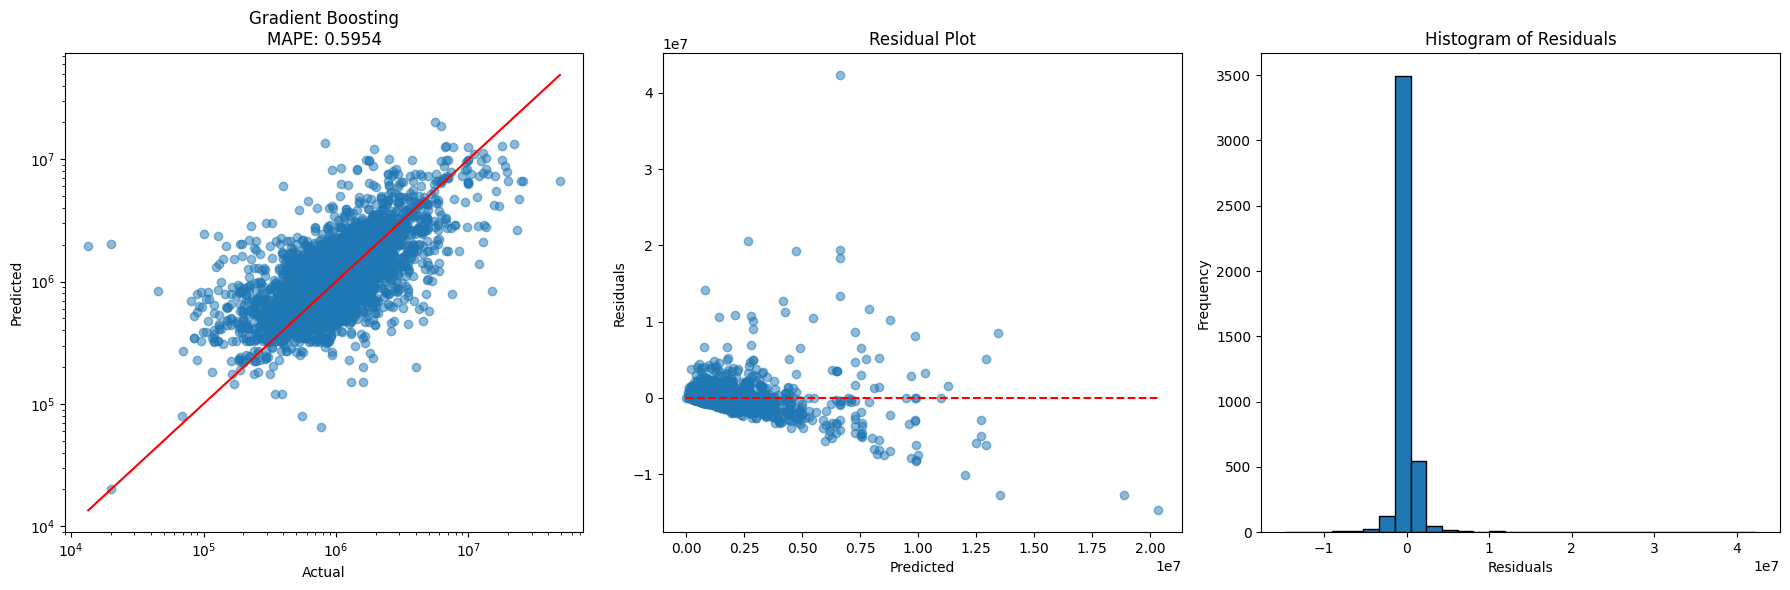

In [70]:
def gb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[None], learning_rate=[0.1]):
    """ Creates a Gradient Boosting model with grid search cv
    """
    gb = GradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [42]
    }

    grid_gb = GridSearchCV(gb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_gb.fit(X_train, y_train)

    best_params = grid_gb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_gb = grid_gb.predict(X_test)

    mape_gb = round(mean_absolute_percentage_error(y_test, y_pred_gb), 4)
    print('MAPE: {}'.format(mape_gb))

    r2_gb = round(r2_score(y_test, y_pred_gb), 4)
    print('R2: {}'.format(r2_gb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_gb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting\nMAPE: {}'.format(mape_gb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_gb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_gb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_gb), max(y_pred_gb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_gb, mape_gb

gb_regression, mape_gb = gb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5
)

mape_lst['Gradient Boosting'] = mape_gb

## Modelle vergleichen

In [71]:
sorted_mape_lst = dict(sorted(mape_lst.items(), key=lambda item: item[1]))
print(sorted_mape_lst)

{'XGBoost': 0.5689, 'Random Forest': 0.579, 'Gradient Boosting': 0.5954, 'Hist Gradient Boosting': 0.6307, 'Ridge Regression': 0.8461, 'Lasso Regression': 0.8475, 'Multiple Linear Regression': 0.8545}


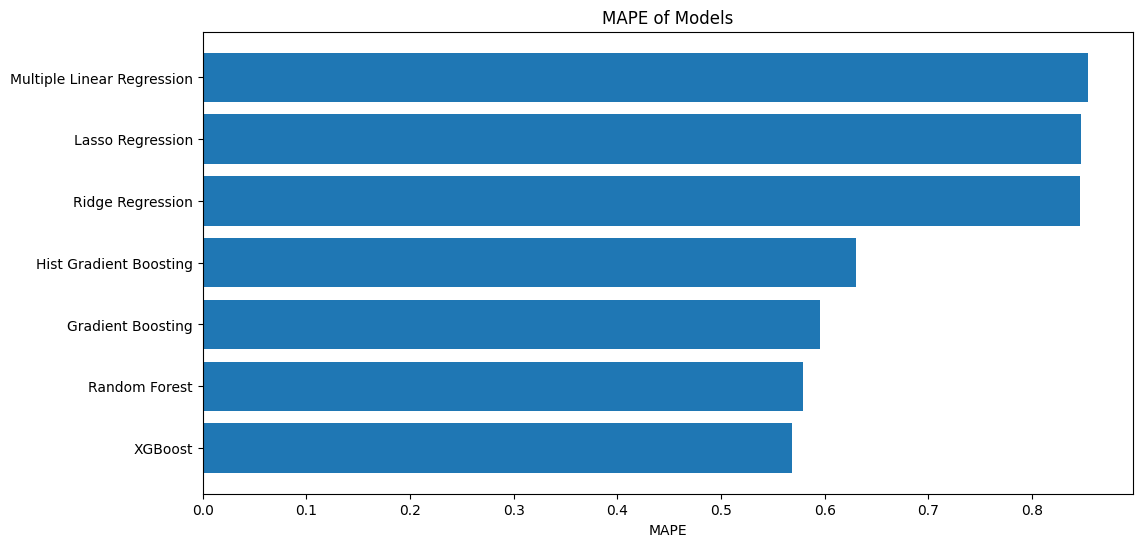

In [72]:
plt.figure(figsize=(12, 6))
plt.barh(list(sorted_mape_lst.keys()), list(sorted_mape_lst.values()))
plt.title('MAPE of Models')
plt.xlabel('MAPE')
plt.show()